In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import statsmodels.api as sm
from start_script import *
from sarimax_script import *
from baseline_script import *
import itertools

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
plt.rc('figure', figsize=(18.0, 6.0))

In [3]:
pd.set_option('display.max_columns', None) 

In [4]:
df = load_building(545, '2016-7-01 00:00:00', '2016-10-31 00:00:00')

In [5]:
df_weather_austin = load_weather('austin')

## ARIMA model

### Explore model

In [6]:
import seasonal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

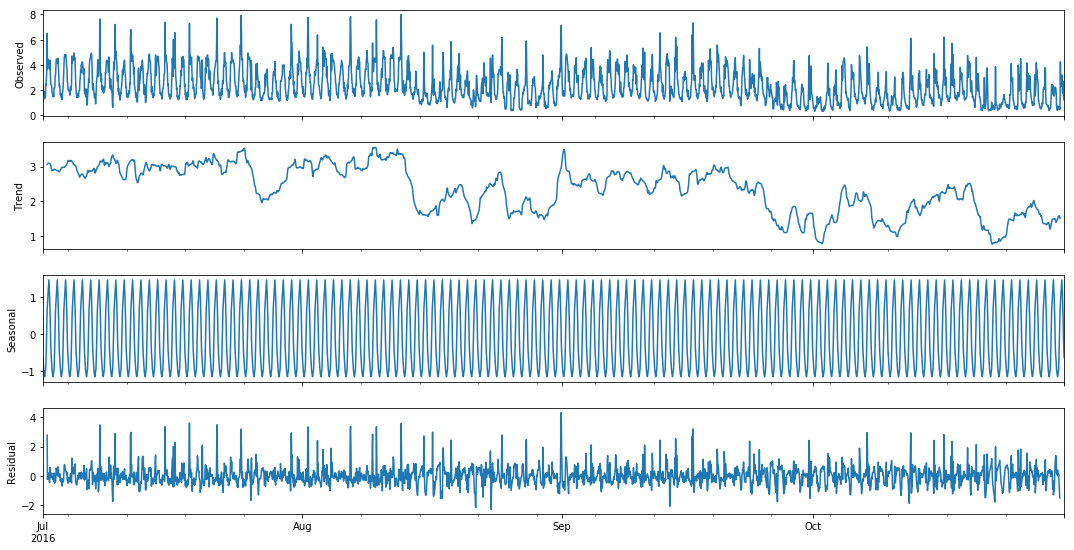

In [7]:
#plot seasonal decomposition
decomposition = seasonal_decompose(df.Hourly_Usage, freq=24)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15,8)

Test stationarity and perform Dicker-Fuller test

In [8]:
#function to test stationarity
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=24)
    rolstd = pd.rolling_std(timeseries, window=24)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.xlabel('Date-Time', fontsize=16)
    plt.ylabel('Energy Consumption (kWh)', fontsize=16)
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput) 

In [9]:
df_stationary = df.loc['2016-10-01 00:00:00':'2016-10-31 00:00:00', :]

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).mean()
  """
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=24,center=False).std()
  


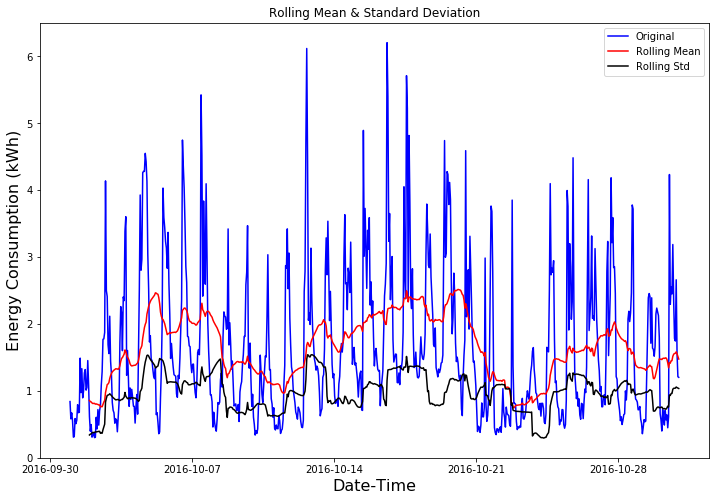

Results of Dickey-Fuller Test:
Test Statistic             -3.169039
p-value                     0.021848
#Lags Used                 20.000000
Number of Observations    700.000000
Critical Value (5%)        -2.865678
Critical Value (1%)        -3.439726
Critical Value (10%)       -2.568973
dtype: float64


In [10]:
test_stationarity(df_stationary.Hourly_Usage)

In [14]:
df_stationary['first_difference'] = df_stationary.Hourly_Usage - df_stationary.Hourly_Usage.shift(1)
# test_stationarity(df_stationary.first_difference)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [17]:
df_stationary['seasonal_difference'] = df_stationary.Hourly_Usage - df_stationary.Hourly_Usage.shift(24)
# test_stationarity(df.seasonal_difference)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
df_stationary['seasonal_first_difference'] = df_stationary.first_difference - df_stationary.first_difference.shift(24)
# test_stationarity(df.seasonal_first_difference)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


PACF and ACF charts

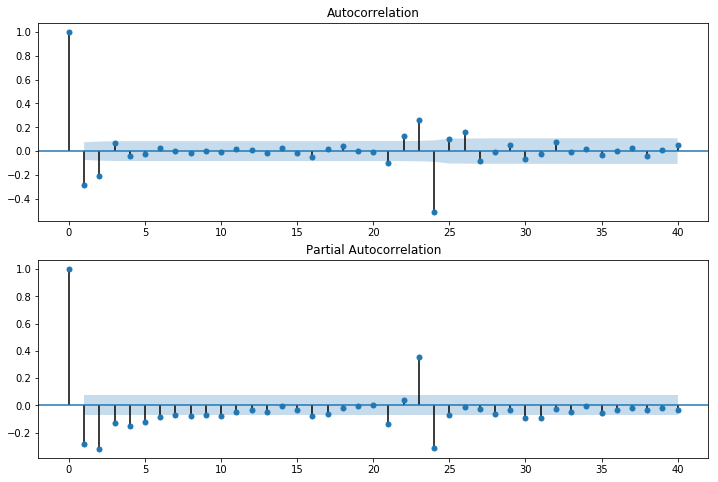

In [21]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_stationary.seasonal_first_difference.iloc[25:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_stationary.seasonal_first_difference.iloc[25:], lags=40, ax=ax2)

In [22]:
start_train, end_train, start_test, end_test = find_dates(545, 10, 120)

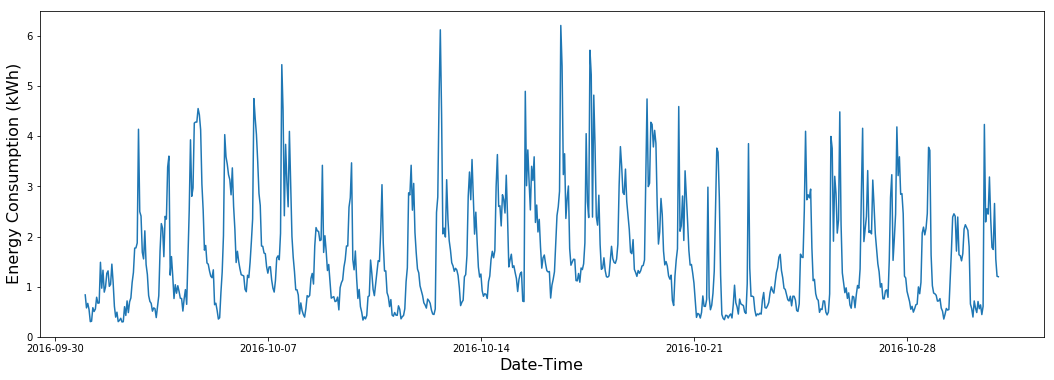

In [23]:
plt.plot(df.loc['2016-10-01 00:00:00':end_test, 'localhour'],df.loc['2016-10-01 00:00:00':end_test, 'Hourly_Usage'])
plt.xlabel('Date-Time', fontsize=16)
plt.ylabel('Energy Consumption (kWh)', fontsize=16)

### Optimize order and seasonal order parameters in SARIMAX model

In [24]:
from datetime import datetime, timedelta
from dateutil.relativedelta import *
import statsmodels.tsa.api as smt
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [25]:
#function to start/end dates for train and test
def find_dates(building_id, length=1, total_length=30, final_date=None):
    start_train, end_test = find_egauge_dates(building_id, total_length)
    time_delta_1 = timedelta(days=length)
    time_delta_2 = timedelta(hours=1)
    end_train = end_test - time_delta_1
    start_test = end_train + time_delta_2
    start_train = str(start_train)
    end_train = str(end_train)
    start_test = str(start_test)
    end_test = str(end_test)

    return start_train, end_train, start_test, end_test


#function to create training and testing set
def create_train_test(data, start_train, end_train, start_test, end_test, test_length=24):

    df_train = data.loc[start_train:end_train, :]
    df_test = data.loc[start_test:end_test, :]

    start = datetime.strptime(start_test, '%Y-%m-%d %H:%M:%S')
    date_list = [start + relativedelta(hours=x) for x in range(0,test_length)]
    future = pd.DataFrame(index=date_list, columns= df_train.columns)
    df_train = pd.concat([df_train, future])

    return df_train, df_test


#function to find optimal parameters and resulting AIC score
def gridsearch_arima(y, exog=None):

    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

    low_aic = [0,0,50000]

    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                model = sm.tsa.statespace.SARIMAX(y,
                                                  exog=exog,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = model.fit()
                if results.aic < low_aic[2]:
                    low_aic = [param, param_seasonal, results.aic]

#                 print('ARIMA{}x{}24 - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    return low_aic


#function to fit arima model without exogenous variables
def fit_arima(data, building_id, length=1, total_length=30):

    start_train, end_train, start_test, end_test = find_dates(building_id, length, total_length)
    df_train, df_test = create_train_test(data, start_train, end_train, start_test, end_test, 24*length)

    y_train = df_train.Hourly_Usage
    low_aic = gridsearch_arima(y_train)

    arima = sm.tsa.statespace.SARIMAX(y_train,
                                  trend=None,
                                  order=low_aic[0],
                                  seasonal_order=low_aic[1],
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

#     arima = sm.tsa.statespace.SARIMAX(y_train,
#                                   trend=None,
#                                   order=(1,0,1),
#                                   seasonal_order=(0,1,1,24),
#                                   enforce_stationarity=False,
#                                   enforce_invertibility=False)
    results = arima.fit()

    return results


# define helper plot function for visualization
def acf_pacf_plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))

    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()


#function to forecast with fitted model, returns MSE and RMSE
def add_forecast(model, test, train, start_time, end_time):

    train['forecast'] = model.predict(start=start_time, end=end_time)
    y_true = test.loc[start_time:end_time, 'Hourly_Usage']
    y_pred = train.loc[start_time:end_time, 'forecast']
    train.loc[start_time:end_time, 'Hourly_Usage'] = test.loc[start_time:end_time, 'Hourly_Usage']

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    return mse, rmse




def plot_forecast(data, datapoints):
    fig = plt.figure(figsize=(16,8))
    plt.plot(data['Hourly_Usage'][datapoints:])
    plt.plot(data['forecast'])
    plt.legend()

In [26]:
arima_results = fit_arima(df, 545, length=10, total_length=120)

In [27]:
arima_results.params

ar.L1       0.528948
ma.L1      -0.954574
ma.S.L24   -1.035956
sigma2      0.340893
dtype: float64

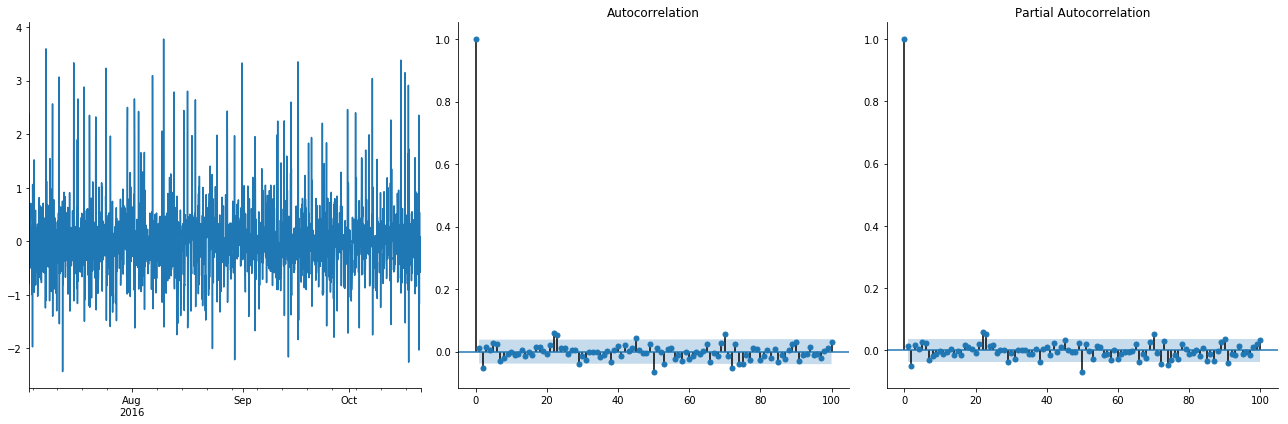

In [28]:
acf_pacf_plots(arima_results.resid.dropna(), lags=100)

In [29]:
start_train, end_train, start_test, end_test = find_dates(545, 10, 120)

In [30]:
df_train, df_test = create_train_test(df, start_train, end_train, start_test, end_test, 240)

(0.81729728776235921, 0.90404495892757419)


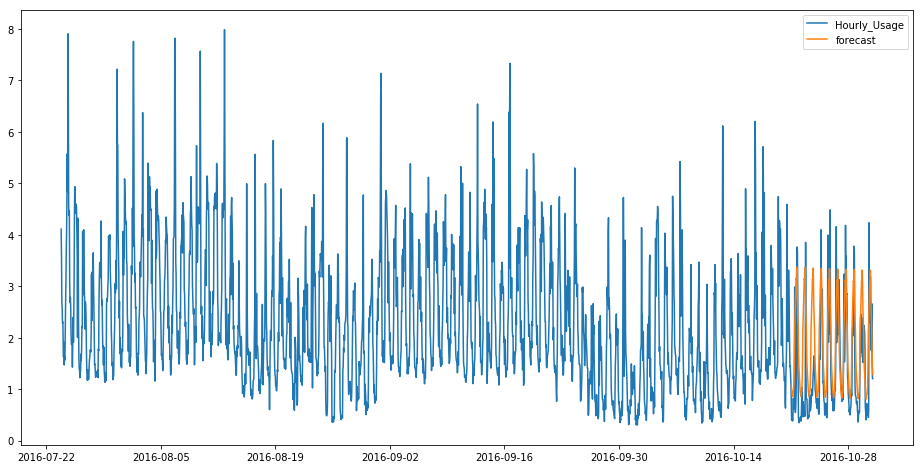

In [31]:
print(add_forecast(arima_results, df_test, df_train, start_test,end_test))
plot_forecast(df_train, 500)

### Add exogenous variables to SARIMAX model

Ideas: day of week (weekend), weather

In [32]:
#function to add all exogenous variables
def create_exog_endo(data, weather, building_id, length=1, total_length=30):

    start_train, end_train, start_test, end_test = find_dates(building_id, length, total_length)
    df_train, df_test = create_train_test(data, start_train, end_train, start_test, end_test, 24*length)

    car_charge = mean_car_charge(data, start_train,end_train)

    df_train['Time_Index'] = df_train.index.weekday_name+ df_train.index.hour.astype(str)
    df_train['Temperature'] = weather.loc[start_train:end_test, 'temperature']
    df_train['Humidity'] = weather.loc[start_train:end_test, 'humidity']

    for time in df_train.loc[start_test:end_test,:].index:
        df_train.loc[time,'car1'] = car_charge[df_train.loc[time,'Time_Index']]

    #fill missing values with mean
    df_train['Temperature'] = df_train.Temperature.fillna(np.mean(df_train['Temperature']))
    df_train['Humidity'] = df_train.Humidity.fillna(np.mean(df_train['Humidity']))

    exogenous = df_train.loc[start_train:,['Temperature','Humidity','car1']].astype(float)
    endogenous = df_train.loc[:,'Hourly_Usage'].astype(float)

    return df_train, exogenous, endogenous



#function to fit SARIMAX model with create_exog_endo
def fit_exog_arima(exogenous, endogenous):

    low_aic = gridsearch_arima(endogenous,exogenous)
    arima_model = sm.tsa.statespace.SARIMAX(endog=endogenous,
                                  exog = exogenous,
                                  trend=None,
                                  order=low_aic[0],
                                  seasonal_order=low_aic[1],
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
    arima_exog_results = arima_model.fit()

    return arima_exog_results


In [33]:
start_trainx, end_trainx, start_testx, end_testx = find_dates(545, 10, 120)
df_trainx, df_testx = create_train_test(df, start_trainx, end_trainx, start_testx, end_testx, 240)

In [34]:
df_train_exog, exogenous, endogenous = create_exog_endo(df, df_weather_austin, 545, 10, 120)

In [35]:
arima_exog_results = fit_exog_arima(exogenous, endogenous)

/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

In [36]:
mse, rmse = add_forecast(arima_exog_results, df_testx, df_trainx, start_test, end_test)

In [37]:
mse, rmse

(0.53617296606795883, 0.73223832600319338)

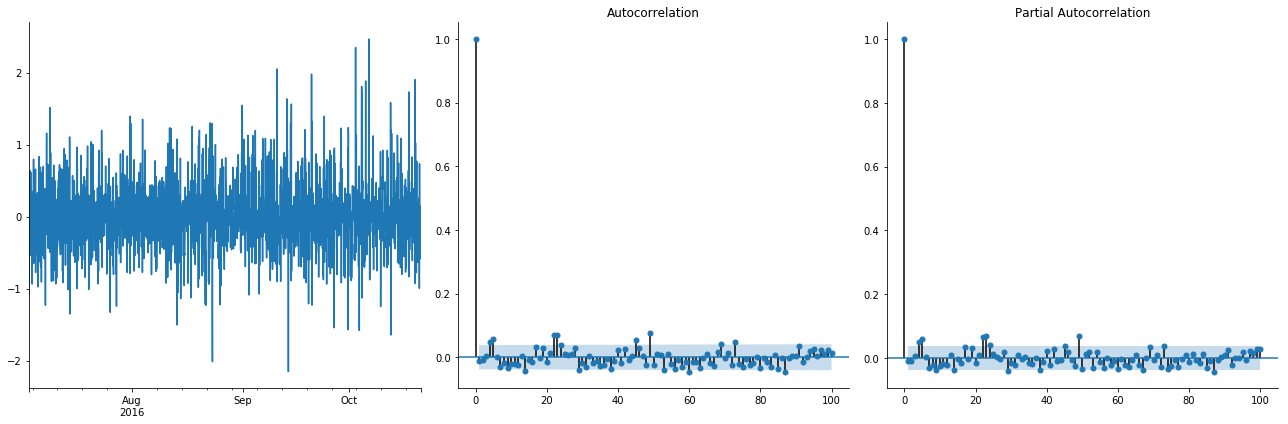

In [38]:
acf_pacf_plots(arima_exog_results.resid.dropna(), lags=100)

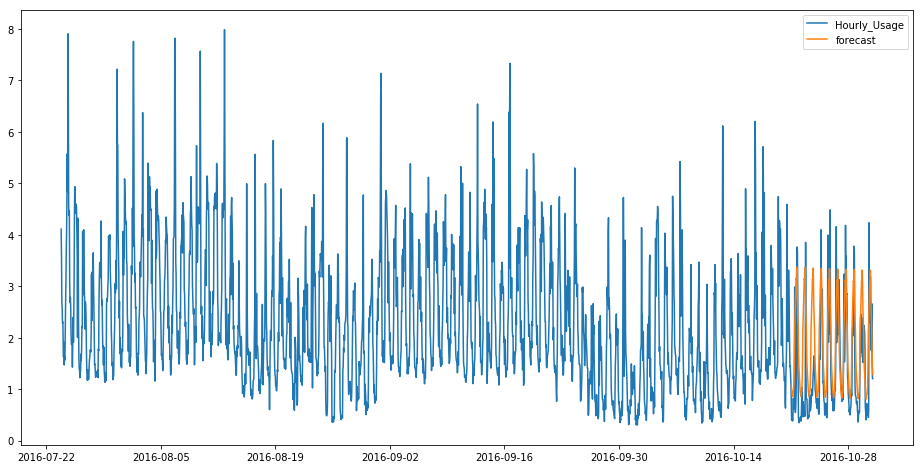

In [39]:
plot_forecast(df_train, 500)

In [40]:
arima_results.params

ar.L1       0.528948
ma.L1      -0.954574
ma.S.L24   -1.035956
sigma2      0.340893
dtype: float64

In [41]:
arima_exog_results.params

Temperature    0.042155
Humidity       0.040788
car1           0.976605
ar.L1          0.562747
ma.L1         -0.961362
ma.S.L24      -0.958555
sigma2         0.183646
dtype: float64

## Baseline model scores (AR and MA)

AR

In [42]:
#function to plot AR forecast and MSE
def ar_scores(data, building_id, p, length=1, total_length=30):
    
    start_train, end_train, start_test, end_test = find_dates(building_id, length, total_length)
    df_baseline_train, df_baseline_test = create_train_test(data, start_train, end_train, start_test, end_test, 24*length)
    df_baseline_train.loc[start_test:,'Hourly_Usage'] = np.nan
    ar_baseline = sm.tsa.statespace.SARIMAX(endog=df_baseline_train.Hourly_Usage,
                                  trend=None,
                                  order=(p, 0, 0),
                                  seasonal_order=(0, 0, 0, 0),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
    results = ar_baseline.fit()
    mse, rmse = add_forecast(results, df_baseline_test, df_baseline_train, start_test, end_test)
    plot_forecast(df_baseline_train, 500)
    
    return mse, rmse

(0.61308730503502162, 0.78299891764613672)

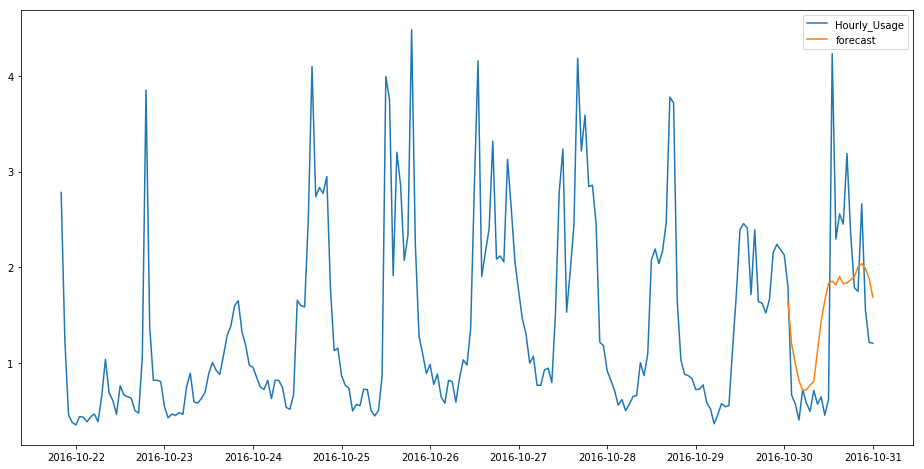

In [43]:
ar_scores(df, 545, 24, 10, 120)

MA

In [44]:
#function to plot AR forecast and MSE
def ma_scores(data, building_id, q, length=1, total_length=30):
    
    start_train, end_train, start_test, end_test = find_dates(building_id, length, total_length)
    df_baseline_train, df_baseline_test = create_train_test(data, start_train, end_train, start_test, end_test, 24*length)
    df_baseline_train.loc[start_test:,'Hourly_Usage'] = np.nan
    ar_baseline = sm.tsa.statespace.SARIMAX(endog=df_baseline_train.Hourly_Usage,
                                  trend=None,
                                  order=(0, 0, q),
                                  seasonal_order=(0, 0, 0, 0),
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)
    results = ar_baseline.fit()
    mse, rmse = add_forecast(results, df_baseline_test, df_baseline_train, start_test, end_test)
    plot_forecast(df_baseline_train, 500)
    
    return mse, rmse

(2.889691176916457, 1.6999091672546676)

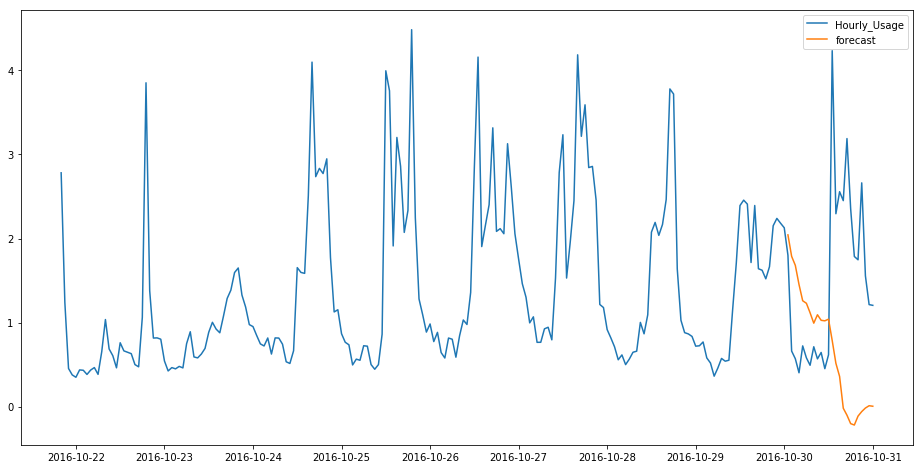

In [45]:
ma_scores(df, 545, 24, 10, 120)